<a href="https://colab.research.google.com/github/knobelsp/BlandAltman/blob/main/BlandAltman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### A statistically sound method to test data against a reference
Kirk Knobelspiesse, kirk.d.knobelspiesse@nasa.gov




**We've all done it...
that is, tested our dataset / algorithm output / etc. against a reference with a simple $x$ vs $y$ scatterplot**.
Perhaps we fit a line to the results, or calculated the correlation coefficient. 

*But is this really the right way to test how our data compares to a reference?* 

**The answer is no**, and there is substantial literature to support this (e.g.
<a href="https://doi.org/10.1364/OE.26.007404">Seegers et al., 2018</a>). But that doesn't stop many of us from making a simple plot, calculating default statistics and calling it a day. Perhaps our motivation is the perceived approachability and simplicity. Maybe we're not aware of the statistical unsuitability. Or maybe we calculated a correlation of 0.97, and that sounds good enough, right?
 

### This notebook demonstrates simple alternatives: Bland-Altman plots and corresponding metrics

**The fundamental problem we're addressessing is "can measurement $y$ replace measurement $x$".** For example, we might have geophysical parameters retreived from an analysis of satellite data that we're comparing to ground based measurements, or results of a trained neural network that we wish to assess against independent validation data. In these cases, we have paired measurements, ie $[(x_1,y_1),(x_2,y_2),(x_3,y_3),...]$, that we would like to assess in aggregate. No single numerical metric can wholly express the 'quality' of the comparison. We instead need several metrics, such as:
 - mean bias between $x$ and $y$
 - scatter in the relationship between $x$ and $y$
 - scale dependence of bias and scatter

While all of these things can be visually inferred from a scatterplot, they are more directly expressed with a *Bland-Altman plot* and corresponding metrics. These techniques are described in <a href="https://doi.org/10.2307/2987937">Altman and Bland, 1983</a>, <a href="https://doi.org/10.1016/S0140-6736(86)90837-8">Bland and Altman, 1986</a> and many subsequent publications (e.g. <a href="https://dx.doi.org/10.1016/j.ijnurstu.2009.10.001">Bland and Altman, 2010</a>, 
<a href="https://doi.org/10.1093/clinchem/48.5.799">Dewitte et al., 2002</a>). An alternative name for this approach is the *Tukey mean-difference plot* and other field specific names, and there is ample evidence of similar analysis that predates Bland and Altman's highly cited papers (e.g. <a href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.632.3728&rep=rep1&type=pdf">Eksborg, 1981</a>). 

As we will demonstrate, $x$ vs. $y$ scatterplots are less effecive at assessing agreement between a pair of measurement types than a Bland-Altman plot. Even more problemmatic are the statistical metrics that are often used in conjunction, including:
 - linear regression (i.e. y = mx +b fits)
 - correlation coefficients (such as the Pearson' linear or the Spearman's rank correlation coefficients)
 - root mean square error (RMSE)
 
The abovementioned literature discusses the inadaquacy of these metrics. **Instead, this notebook is intended to be a graphical demonstration of the advantages of the Bland-Altman approach, with side by side comparisons of various datasets.**

### Before starting, compile this code...

In [1]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats
from collections import namedtuple
from BlandAltman import plot_BAvsScat

#!pip install pangaeapy
#from pangaeapy import PanDataSet


### The Bland-Altman technique

The Bland-Altman plot differs from a regular scatterplot in that the bias between each pair of measurements is graphed against the paired mean. Rather than plotting $x$ versus $y$ for paired measurements $[(x_1,y_1),(x_2,y_2),(x_3,y_3),...]$, we instead calculate the paired mean ($m_i$) and bias ($b_i$):

$m_i = \frac{x_i+y_i}{2}$

$b_i = y_i - x_i $

Thus, the Bland-Altman plot represents $m$ versus $b$. While this contains the same information as the scatterplot, it clearly and independently visualizes the most relevant and robust metrics for comparisons of measurement techniques: bias, scatter, and scale dependence.

We'll describe those in detail in a moment, but for now let's start with a simple example based on randomly generated numbers. 


Bias INDEPENDENT of paired mean, r:-0.041


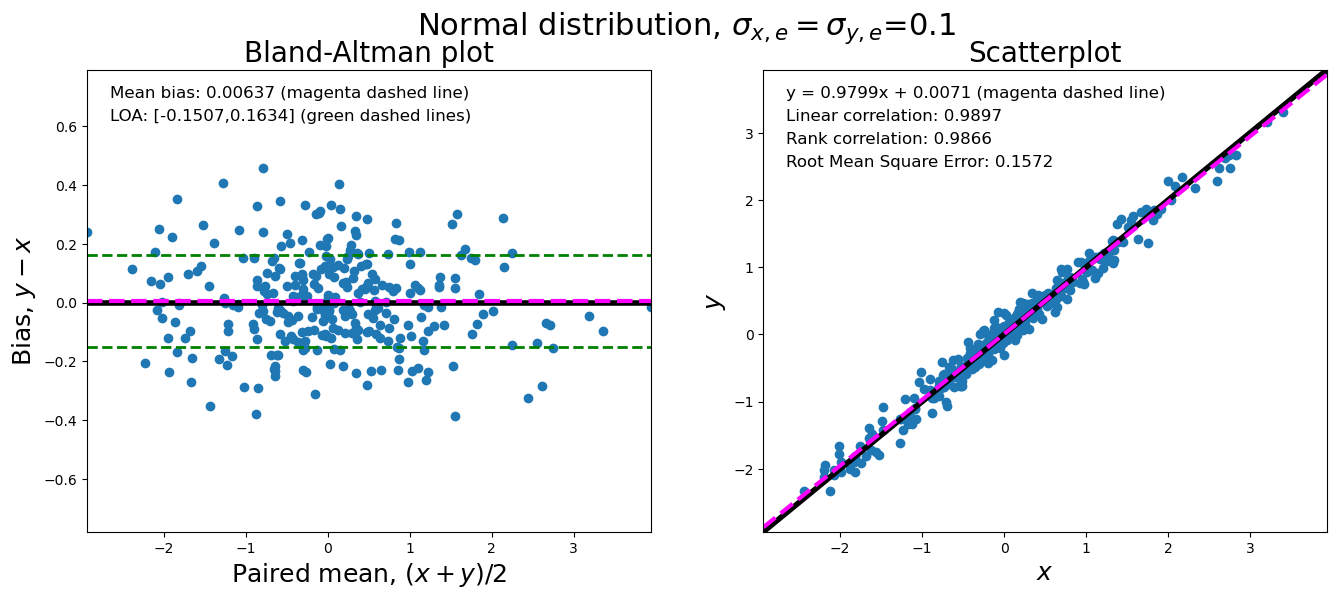

In [2]:
leng=300 #this is how many data points will be in the example
source=np.random.standard_normal(size=(leng)) #this is the true value
random_error=0.1 #set a random error of 10% as wide as a standard normal distribution

xx_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
xx= source + xx_error_rand #x is the true value (source) plus random errors

yy_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
yy= source + yy_error_rand #y is the true value (source) plus random errors

ba_norm_nobias=plot_BAvsScat(xx,yy,label='Normal distribution, $\sigma_{x,e}=\sigma_{y,e}$=0.1',scat=1)

Bias INDEPENDENT of paired mean, r:-0.061


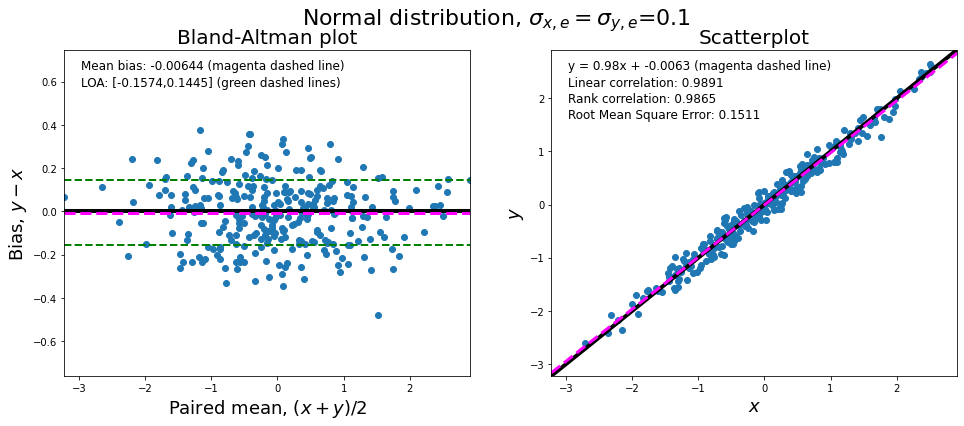

Above, we show the Bland-Altman plot at left and a standard scatterplot at right. The source data are randomly selected from a zero mean, $\sigma$=1 Gaussian normal distribution. 'Measurements' of these data, expressed in $x$ and $y$, include random errors from a zero mean normal distribution with $\sigma_e$=0.1.

$x$ and $y$ represent different measurement systems with (only) random errors for each observation. The mean of the $y-x$ bias is therefore close to zero. This is clear in the Bland-Altman plot, where it has been labeled with a dashed magenta line. It is also shown in the scatterplot at right, and in the linear fit to the data (also a magenta dashed line) which is close to $y = 1.0x + 0.0$. Both the linear (Pearson) and rank (Spearman) correlation coefficients are 'high', although it is difficult to connect the specific meaning of those values to the data itself. The **mean bias, $\bar{b}$**, on the other hand, is a metric expressed in the units of the measurement, and clearly shown in the Bland-Altman plot ($\bar{b}$ is also referred to as the mean absolute error, MAE). 

A significant difference between the Bland-Altman plot and scattplot is how random errors (scatter) are represented. It is readily apparent in the Bland-Altman plot. The amount of this scatter can be exprssed with the **Limits of Agreement, LOA**:

$LOA = [\bar{b}-s, \bar{b}+s]$

where $s$ is the standard deviation of $b$. Here, we're using a one sigma basis for LOA, although some define it at two sigma or other multiples of $s$. In the example above, LOA approximately represents $\pm$ the squared sum of the $\sigma_e$ random errors for $x$ and $y$ (with no bias). The RMSE is similar, although that is only the case for systems with no bias.

**The LOA expresses expectations of agreement between $x$ and $y$. When it is defined at one sigma, we can expect the $y-x$ difference to fall within this range roughly 68.2% of the time** (see below for further qualifications regarding scale dependence).

Like $\bar{b}$, the LOA has the same units as the measurement. There is no equivalent in a scatterplot, linear regression to $x$ and $y$, or correlation coefficients. The latter are, of course, close to 1 for minimal bias and scatter systems, but multiple factors can cause the correlation coefficient to decrease. 


### Example with random and systemmatic errors

Next, we'll demonstrate the case where one of the measurement systems ($y$) has both random and systemmatic errors. 

Bias INDEPENDENT of paired mean, r:0.102


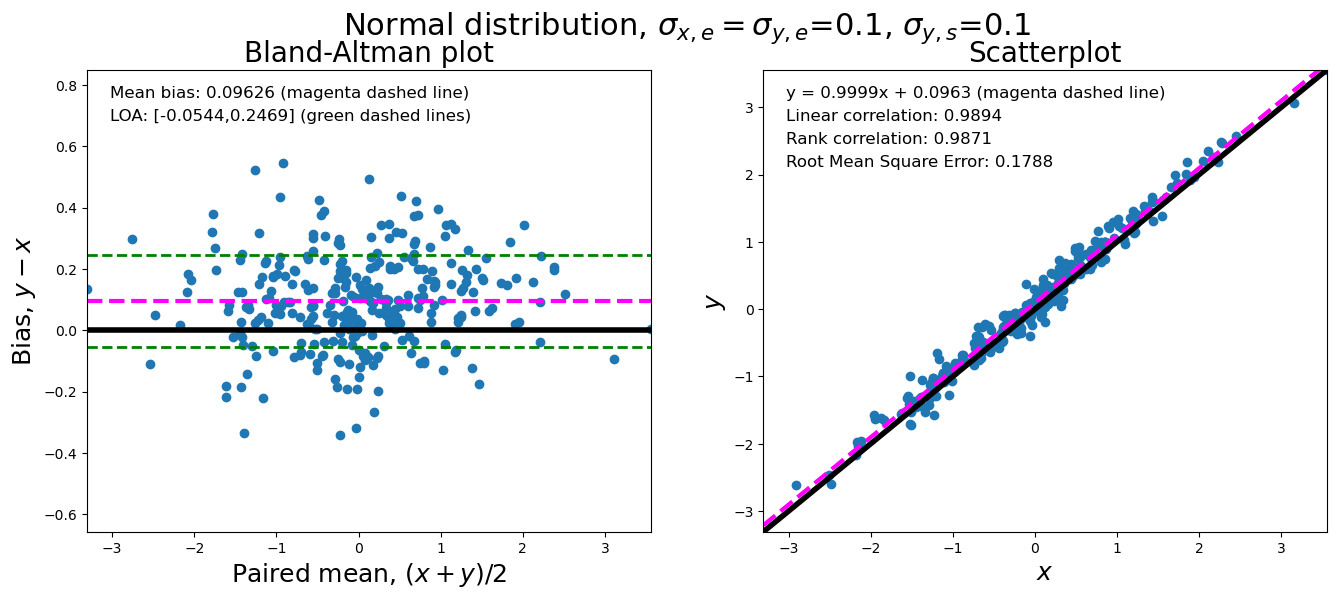

In [9]:
leng=300
source=np.random.standard_normal(size=(leng)) #this is the true value
random_error=0.1 #set a random error of 10% as wide as a standard normal distribution

xx_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
xx= source + xx_error_rand #x is the true value (source) plus errors

yy_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
yy_error_syst= 0.1 #systemmatic error for measurement y
yy= source + yy_error_rand + yy_error_syst #y is the true value (source) plus  errors

ba_norm_bias=plot_BAvsScat(xx,yy,label='Normal distribution, $\sigma_{x,e}=\sigma_{y,e}$=0.1, $\sigma_{y,s}$=0.1',scat=1)

In this case we can see the advantage of the Bland-Altman style plot and analysis, as the bias of $y$ compared to $x$ is clearly present (note the automatically adjusting axis range in our plotting function), and the observed $\bar{b} \approx \sigma_{y,s} - \sigma_{x,s} = 0.1$. The LOA range is similar to that of the previous example, but shifted by the amount of $\bar{b}$. 

Although random and systemmatic errors are equivalent in magnitude, the scatterplot appears nearly identical to the previous example, which had no systemmatic error. The only indication of systemmatic error is expressed in the linear regression y intercept. Additionally, since the RMSE represents both systemmatic and random errors, it is impossible to determine the source of the increase compared to the previous case. 

### Example with non-normal numerical distributions

Non-Gaussian normal numerical distributions can impact the robustness of regression and correlation metrics. Unfortunately, our data frequently have non-Gaussian distributions. Here we give examples of the impacts of different distributions.

Bias INDEPENDENT of paired mean, r:-0.055


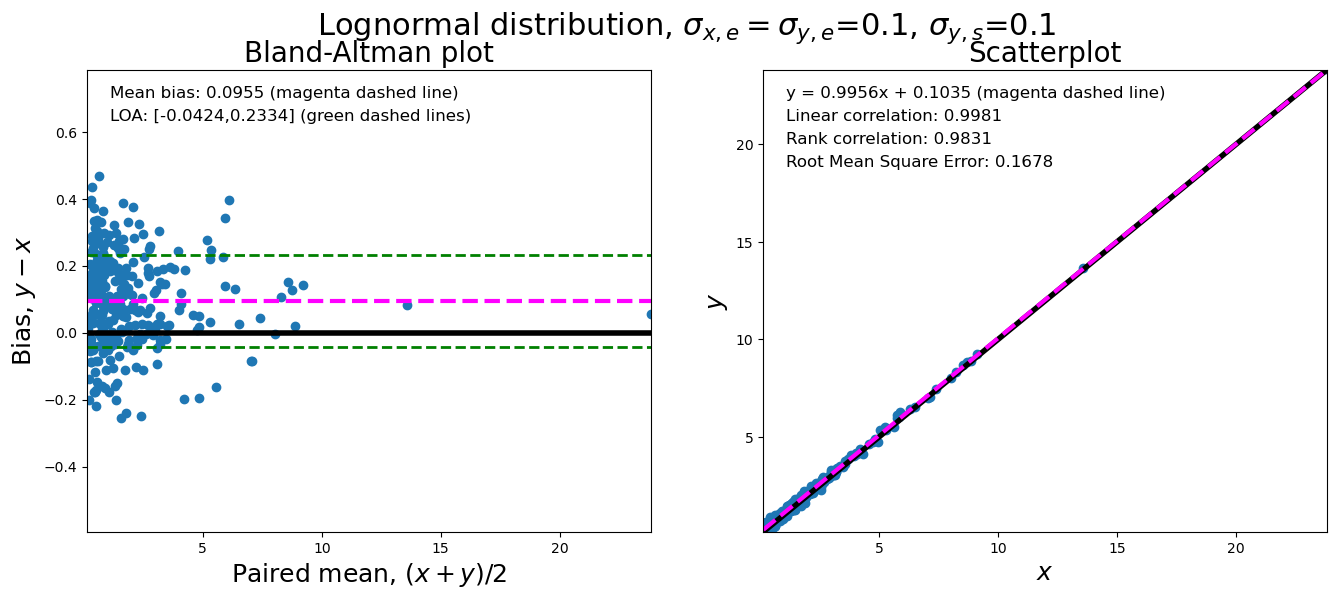

In [10]:
leng=300
source=np.random.lognormal(0.1,1,size=(leng)) #this is the true value
random_error=0.1 #set a random error of 10% as wide as a standard normal distribution

xx_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
xx= source + xx_error_rand #x is the true value (source) plus errors

yy_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
yy_error_syst= 0.1 #systemmatic error for measurement y
yy= source + yy_error_rand + yy_error_syst #y is the true value (source) plus  errors

ba_lognorm_bias=plot_BAvsScat(xx,yy,label='Lognormal distribution, $\sigma_{x,e}=\sigma_{y,e}$=0.1, $\sigma_{y,s}$=0.1',scat=1)

Bias INDEPENDENT of paired mean, r:-0.058


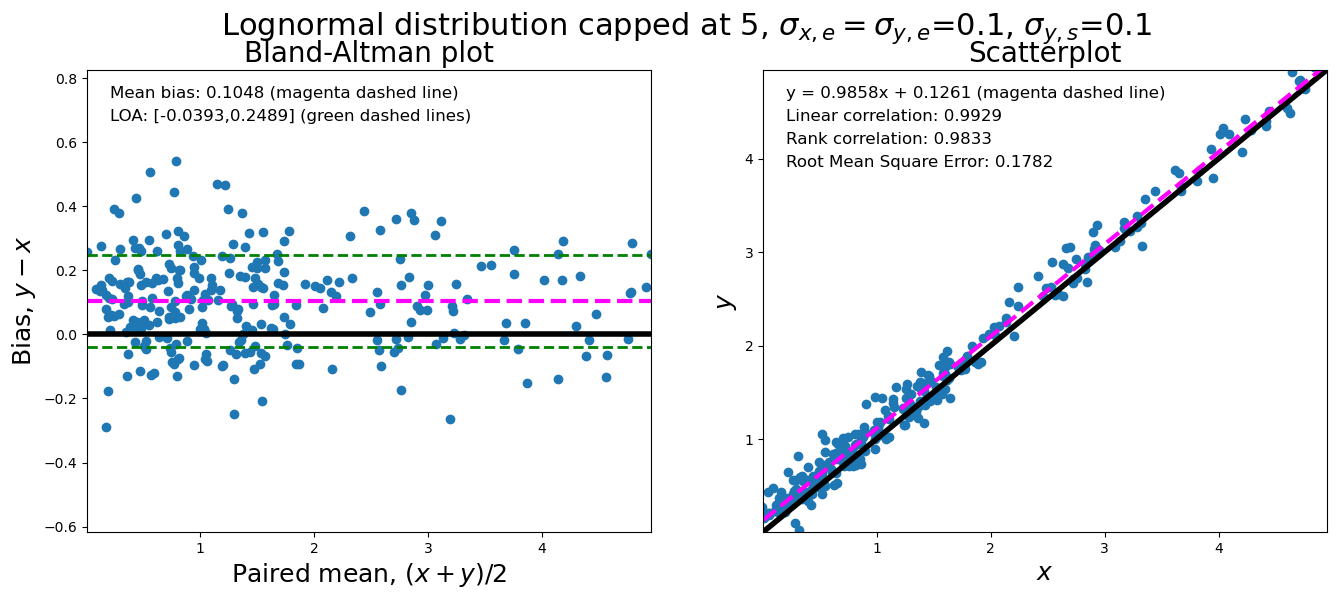

In [11]:
leng=300
source=np.random.lognormal(0.1,1,size=(leng)) #this is the true value
source=source[source <=5] #cap source data at 3
leng=len(source)

random_error=0.1 #set a random error of 10% as wide as a standard normal distribution

xx_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
xx= source + xx_error_rand #x is the true value (source) plus errors

yy_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
yy_error_syst= 0.1 #systemmatic error for measurement y
yy= source + yy_error_rand + yy_error_syst #y is the true value (source) plus  errors

ba_lognormcap_bias=plot_BAvsScat(xx,yy,label='Lognormal distribution capped at 5, $\sigma_{x,e}=\sigma_{y,e}$=0.1, $\sigma_{y,s}$=0.1',scat=1)

Bias INDEPENDENT of paired mean, r:0.011


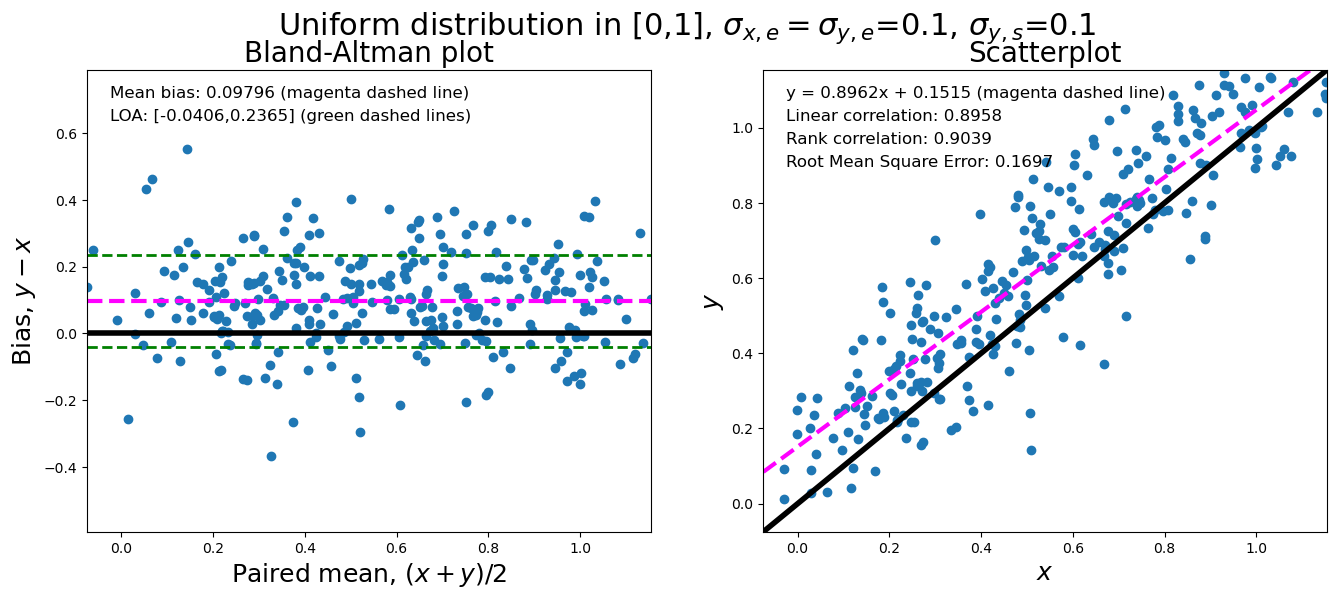

In [12]:
leng=300
source=np.random.uniform(0,1,size=(leng)) #this is the true value
random_error=0.1 #set a random error of 10% as wide as a standard normal distribution

xx_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
xx= source + xx_error_rand #x is the true value (source) plus errors

yy_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
yy_error_syst= 0.1 #systemmatic error for measurement y
yy= source + yy_error_rand + yy_error_syst #y is the true value (source) plus  errors

ba_uniform_bias=plot_BAvsScat(xx,yy,label='Uniform distribution in [0,1], $\sigma_{x,e}=\sigma_{y,e}$=0.1, $\sigma_{y,s}$=0.1',scat=1)

We've plotted the results of data with three numerical distributions commonly encountered in the remote sensing validation community: 

 - lognormal distributions (encountered with atmospheric *Aerosol Optical Thickness (AOT)* (<a href="https://doi.org/10.5194/acp-19-15023-2019">Sayer and Knobelspiesse, 2019</a>) or oceanic *Chlorophyll-a* concentration (<a href="https://doi.org/10.1029/95JC00458">Campbell, 1995</a>))
 - capped lognormal distributions (due to algorithm pre-screening such as the case when high *AOT* is misinterpretated as a cloud), and
 - uniform distributions in the $[0,1]$ range, for fractional concentrations of geophysical parameters.

The derived statistical metrics for these three cases (and our particular random number generator seed) were:



In [8]:
ba_uniform_bias

BlandAltman(scaleindependence=True, meanbias=0.11109, loa=(-0.037, 0.2592), slope=0.8573727098744852, yintercept=0.1812532663356517, lincorr=0.8723543025698827, rankcorr=0.8804266714074601, rmse=0.18516772376473004)

In [17]:
dat={'Normal':ba_norm_bias, 'Lognormal':ba_lognorm_bias, 'Lognormal, capped':ba_lognormcap_bias, 'Uniform':ba_uniform_bias}
df = pd.DataFrame(dat, index=['Scale independent','Mean bias','LOA','Slope','Y-intercept','Correlation','Rank Correlation','RMSE'])
pd.set_option('display.precision', 4)
df

,Normal,Lognormal,"Lognormal, capped",Uniform
Scale independent,True,True,True,True
Mean bias,0.0925,0.1151,0.0897,0.1111
LOA,"(-0.0449, 0.2299)","(-0.0153, 0.2455)","(-0.0505, 0.2299)","(-0.037, 0.2592)"
Slope,0.9906,1.0017,0.9928,0.8574
Y-intercept,0.0931,0.1121,0.0996,0.1813
Correlation,0.9913,0.9986,0.9926,0.8724
Rank Correlation,0.9909,0.9862,0.9826,0.8804
RMSE,0.1657,0.1739,0.1665,0.1852


While the mean bias and LOA are insensitive to these different numerical distributions, the regression and correlation coefficients are not. This is especially obvious for the uniform distribution, for which a regression consistently underestimates the slope and overestimates the y-intercept. Correlation coefficients for the lognormal capped and uniform distributions are less than that for other distributions, which would lead to an interpretation of diminished agreement between measurement methods, when in fact nothing has changed about the measurement system. 


### Systemmatic error scale dependence

The examples we've investigated so far had systemmatic errors that did not depend on the magnitude of the source data. If instead this is the case, none of the statistical metrics presented above are particularly meaningful. However, the Bland-Altman plot clearly visualizes when that is so. Additionally, a simple hypothesis test can be performed for verification. Here, we show examples of a scale dependent bias, and how it is expressed and assessed with a Bland-Altman plot and a scatterplot.

Bias DEPENDENT on paired mean, r:0.587


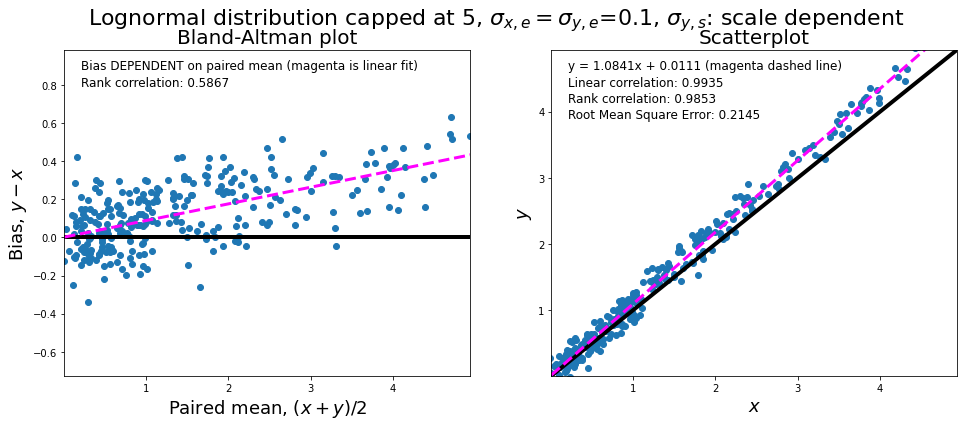

In [10]:
leng=300
#source=np.random.standard_normal(size=(leng)) #this is the true value

source=np.random.lognormal(0.1,1,size=(leng)) #this is the true value
source=source[source <=5] #cap source data at 3
leng=len(source)

random_error=0.1 #set a random error of 10% as wide as a standard normal distribution

xx_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
xx= source + xx_error_rand #x is the true value (source) plus errors

yy_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
yy_error_syst= 0.1 * source #systemmatic error for measurement y
yy= source + yy_error_rand + yy_error_syst #y is the true value (source) plus  errors

ba_lognormcap_scalebias=plot_BAvsScat(xx,yy,label='Lognormal distribution capped at 5, $\sigma_{x,e}=\sigma_{y,e}$=0.1, $\sigma_{y,s}$: scale dependent',scat=1)

In this example, we created a system where $y$ has a scale dependent bias: it increases as the data values increase. For this reason, $\bar{b}$ and LOA no longer have meaning - and this is clear from the Bland-Altman plot. Evidence for this also exists in the scatterplot, although it is less obvious. While the slope of the linear regression indicates the possibility of a scale dependent bias, it does not indicate a threshold for when it does in fact exist. Correlation coefficients are otherwise unaffected, providing no warning that this is the case.

Because a scale dependent bias renders $\bar{b}$ and LOA meaningless, we must establish that it does not exist before calculating those values. <a href="https://doi.org/10.2307/2987937">Altman and Bland, 1983</a>, proposed performing a hypothesis test with a paired t-test. To do so, we calculate the rank correlation between paired mean and bias (an appropriate use of that metric), and compare to a p-value of 0.05. If the bias is found to be independent of the mean, then we conclude that $\bar{b}$ and LOA are meaningful metrics. Otherwise, some adjustment or data partitioning must be performed. <a href="https://doi.org/10.2307/2987937">Altman and Bland, 1983</a> recommend a 'transformation,' perhaps a bias correction, such that the scale dependence is removed. 

Because the example above has a scale dependent bias, a rank correlation coefficient for $m$ vs $b$ is large enough that we are no longer confident that they are independent. The plotting/analysis function in this notebook (*plot_BAvsScat*) performs this test and decidies whether or not to calculate and plot $\bar{b}$ and LOA. Scale dependence is visualized clearly in a Bland-Altman plot, so there is value in making it even if $\bar{b}$ and LOA cannot be calculated. Scale dependence is much less obvious in a traditional scatterplot.
  

### Random error scale dependence (heteroscedasticity)

Another form of scale dependence is if random variations change with scale, also known as heteroscedasticity. In this case, the mean bias, $\bar{b}$, is unaffected, but the LOA are not meaningful. In the example below, we create random errors that get larger with scale. 

Bias INDEPENDENT of paired mean, r:0.069


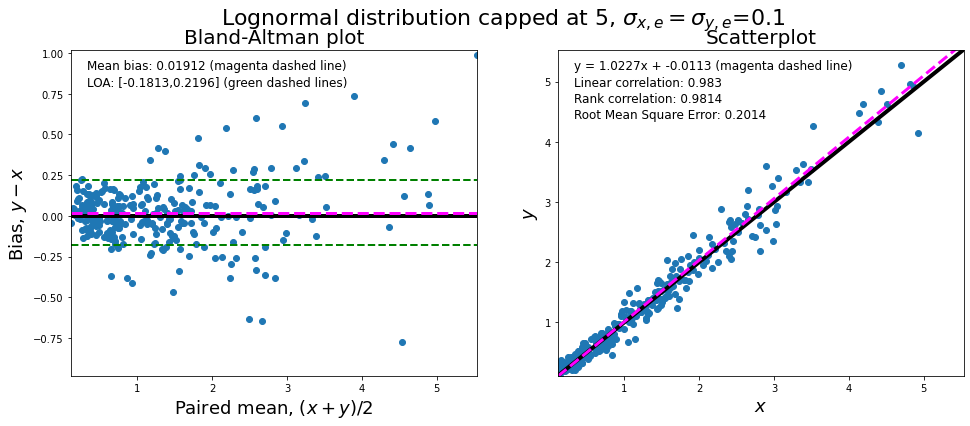

In [11]:
leng=300
#source=np.random.standard_normal(size=(leng)) #this is the true value

source=np.random.lognormal(0.1,1,size=(leng)) #this is the true value
source=source[source <=5] #cap source data at 3
leng=len(source)

random_error=0.1 #set a random error of 10% as wide as a standard normal distribution
xx_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
xx= source + xx_error_rand #x is the true value (source) plus errors

yy_error_rand=random_error*np.random.standard_normal(size=(leng))*source #generate random error for measurement y with heteroscedasticity
yy= source + yy_error_rand #y is the true value (source) plus  errors

ba_lognormcap_randbias=plot_BAvsScat(xx,yy,label='Lognormal distribution capped at 5, $\sigma_{x,e}=\sigma_{y,e}$=0.1',scat=1)

In this case, which is visibly evident in the plot, <a href="https://doi.org/10.2307/2987937">Altman and Bland, 1983</a> also recommend a data transformation. That may look different than a simple bias correction. 

### Incorporating models of instrument uncertainty


Some measurement systems may have models of measurement uncertainty expectations. If these models are complex, such as those that describe uncertainty scale dependence, they can be incorporated into a modified version of Bland-Altman. This modification is demonstrated in <a href="https://doi.org/10.1364/AO.58.000650">Knobelspiesse et al., 2019</a>, and addresses the question:

  *Do measurements agree within uncertainty expectations?*

We therefore modify the bias:

$b_i = y_i - x_i $

To a version normalized by measurement uncertainty model

$b_{N,i} = \frac{y_i - x_i}{(\sigma^2_{x,i} + \sigma^2_{y,i})^{1/2}}$

To demonstrate, we'll show the above example, this time with normalized bias.

Bias INDEPENDENT of paired mean, r:-0.038


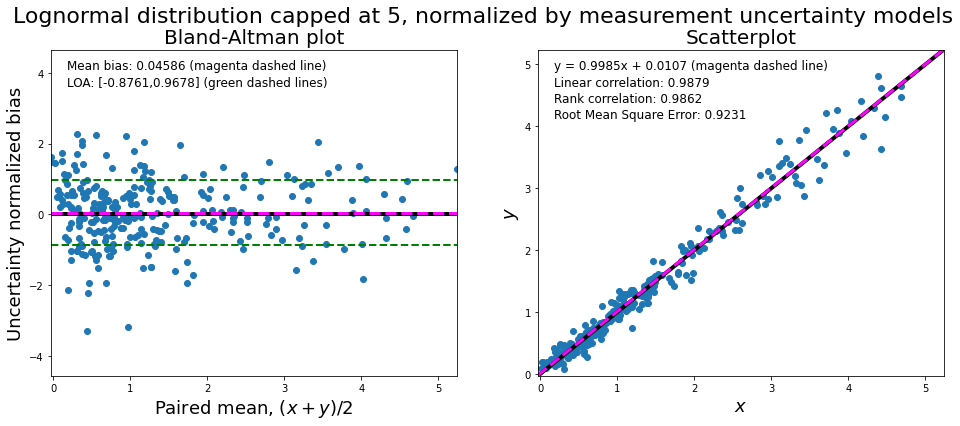

In [12]:
leng=300
#source=np.random.standard_normal(size=(leng)) #this is the true value

source=np.random.lognormal(0.1,1,size=(leng)) #this is the true value
source=source[source <=5] #cap source data at 3
leng=len(source)

random_error=0.1 #set a random error of 10% as wide as a standard normal distribution
xx_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
xx= source + xx_error_rand #x is the true value (source) plus errors
xx_unc_model = random_error

yy_error_rand=random_error*np.random.standard_normal(size=(leng))*source #generate random error for measurement y with heteroscedasticity
yy= source + yy_error_rand #y is the true value (source) plus  errors
yy_unc_model = random_error*source

ba_lognormcap_normal=plot_BAvsScat(xx,yy,label='Lognormal distribution capped at 5, normalized by measurement uncertainty models',scat=1, xx_unc_modl=xx_unc_model, yy_unc_modl=yy_unc_model)

Although there is a scale dependent increase in random error, in this normalized form the LOA are again meaningful. In fact, they should correspond to (nearly) [-1,1] if the uncertainty models are correct and correspond to the same sigma level as was used in LOA. Alternatively, 68.2% of data should fall within that range, and hypothesis tests could be created to prove that this is or is not the case.

### Overplotting

As an aside, scatterplots can also misrepresent the data because of overplotting. 2D histograms avoid this problem, and are generated with *plot_BAvsSCAT* by setting scat=0. 

Bias INDEPENDENT of paired mean, r:-0.010


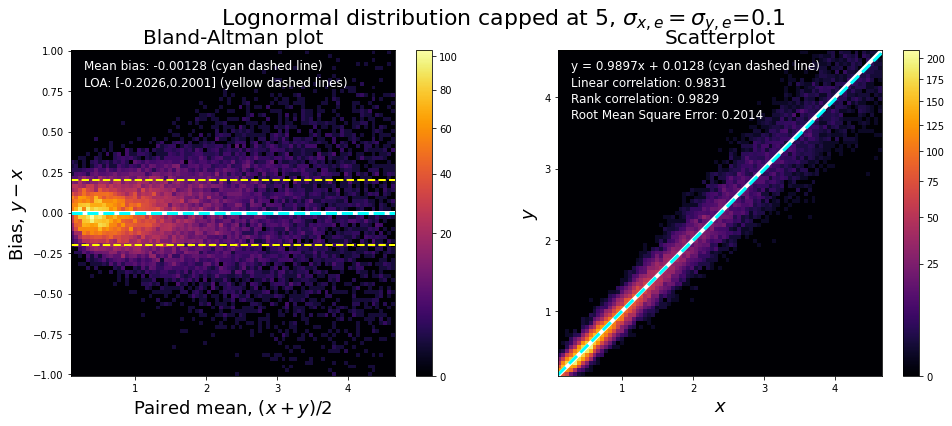

In [13]:
leng=30000
#source=np.random.standard_normal(size=(leng)) #this is the true value

source=np.random.lognormal(0.1,1,size=(leng)) #this is the true value
source=source[source <=5] #cap source data at 3
leng=len(source)

random_error=0.1 #set a random error of 10% as wide as a standard normal distribution
xx_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
xx= source + xx_error_rand #x is the true value (source) plus errors

yy_error_rand=random_error*np.random.standard_normal(size=(leng))*source #generate random error for measurement y with heteroscedasticity
yy= source + yy_error_rand #y is the true value (source) plus  errors

ba_lognormcap_2dhist=plot_BAvsScat(xx,yy,label='Lognormal distribution capped at 5, $\sigma_{x,e}=\sigma_{y,e}$=0.1',scat=0)

### Real world example

<a href="https://doi.org/10.1029/2020GC009449">Balestra et al., 2021</a> tested different methods for determining the Mg/Ca [mmol/mol] geochemical proxy in Foraminifera, a type of marine organism used for paleoclimatic reconstruction. The commonly used 'reference' measurement is made by the use of Laser Ablation Inductively Coupled Plasma Mass Spectrometry (LA-ICP-MS). The authors tested if an X-Ray Spectroscopy by electron probe microanalyzer (EPMA) can make an equivalent measurement of the Mg/Ca ratio. 

In [14]:
#read data files
universa=PanDataSet('10.1594/PANGAEA.926486')
uvigerina=PanDataSet('10.1594/PANGAEA.926484')
uvigerina.data.columns

Index(['Sample ID', 'Uvigerina spp. Mg/Ca', 'Uvigerina spp. Mg/Ca_2',
       'Uvigerina spp. Mg/Ca_3', 'Uvigerina spp. Mg/Ca_4', 'Event', 'Latitude',
       'Longitude', 'Elevation', 'Date/Time'],
      dtype='object')

Balestra et al., 2021 first tested with samples from shells of the Foraminifera species *Uvigerina spp.*. They found minimal bias and LOA within a large, but acceptable range (note that that publication defined LOA at a different range than the one sigma case we're using here). This was encouraging for the use of the EPMA measurement technique as a replacement for LA-ICP-MS technique.

Bias INDEPENDENT of paired mean, r:-0.039


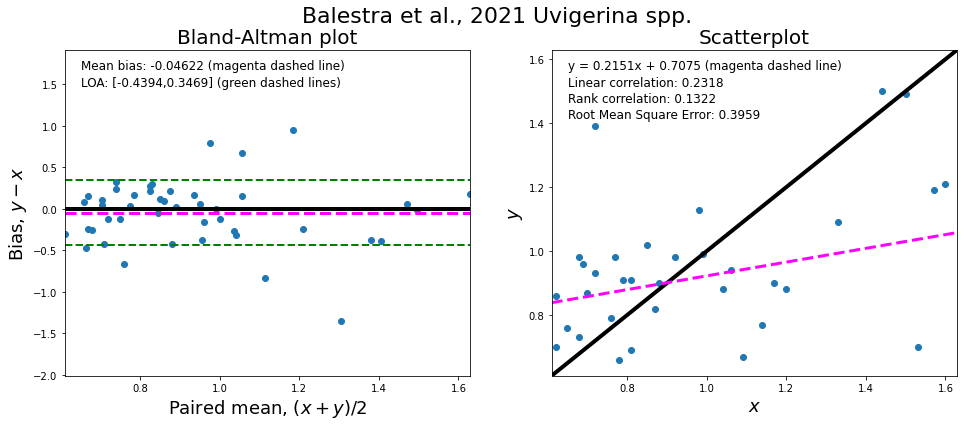

In [15]:
uvigerina_epma=np.asarray(uvigerina.data['Uvigerina spp. Mg/Ca'])
uvigerina_laicpms=np.asarray(uvigerina.data['Uvigerina spp. Mg/Ca_3'])
ba_uvigerina=plot_BAvsScat(uvigerina_laicpms,uvigerina_epma,label='Balestra et al., 2021 Uvigerina spp.',scat=1)

Bias DEPENDENT on paired mean, r:0.377


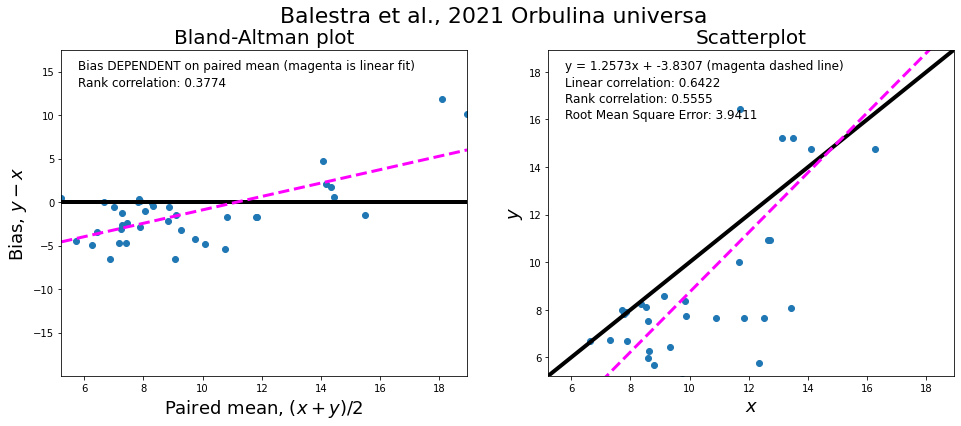

In [16]:

universa_epma=np.asarray(universa.data['O. universa Mg/Ca'])
universa_laicpms=np.asarray(universa.data['O. universa Mg/Ca_3'])
ba_universa=plot_BAvsScat(universa_laicpms,universa_epma,label='Balestra et al., 2021 Orbulina universa',scat=1)

Next, Balestra et al., 2021 tested with samples from shells of the Foraminifera species *Orbulina universa*. Note that the Mg/Ca ratios are much higher for this species, representing a different measurement domain. At these larger values there does appear to be a scale dependent bias. Generally speaking, for values in the 5 < Mg/Ca [mmol/mol] < 13 range, the EMPA measurement is biased smaller than LA-ICP-MS on average by 2.44 [mmol/mol] (value from manuscript). Larger than 13[mmol/mol] there is a clear scale dependent bias, and EMPA data cannot be considered a replacement of LA-ICP-MS without further transformation. 

###Conclusions

To do. Perhaps also a section on when scatterplots, regressions and correlation are indeed appropriate. 

**References**

Altman, D. G. and Bland, J. M.: Measurement in medicine: the analysis of method comparison studies, The statistician, 307--317 , 1983.

Balestra, B., Rose, T., Fehrenbacher, J., Knobelspiesse, K. D., Huber, B. T., Gooding, T., and Paytan, A.: In Situ Mg/Ca Measurements on Foraminifera: Comparison Between Laser Ablation Inductively Coupled Plasma Mass Spectrometry and Wavelength-Dispersive X-Ray Spectroscopy by Electron Probe Microanalyzer, Geochemistry, Geophysics, Geosystems, 22(2), e2020GC009449 , https://doi.org/https://doi.org/10.1029/2020GC009449, 2021.

Bland, J. M. and Altman, D.: Statistical methods for assessing agreement between two methods of clinical measurement, The lancet, 327(8476), 307--310 , 1986.

Bland, J. M. and Altman, D. G.: Comparing methods of measurement: why plotting difference against standard method is misleading, The lancet, 346(8982), 1085--1087 , 1995.

Bland, J. M. and Altman, D. G.: Measuring agreement in method comparison studies, Statistical methods in medical research, 8(2), 135--160 , 1999.

Bland, J. M. and Altman, D. G.: Statistical methods for assessing agreement between two methods of clinical measurement, International Journal of Nursing Studies, 47(8), 931--936 , 2010.

Campbell, J. W.: The lognormal distribution as a model for bio-optical variability in the sea, J. Geophys. Res., 100(C7), 13237-13254 , 1995.

Chhapola, V., Kanwal, S. K., and Brar, R.: Reporting standards for Bland--Altman agreement analysis in laboratory research: a cross-sectional survey of current practice, Annals of Clinical Biochemistry, 52(3), 382-386 , https://doi.org/10.1177/0004563214553438, 2015.

Dewitte, K., Fierens, C., Stöckl, D., and Thienpont, L. M.: Application of the Bland--Altman Plot for Interpretation of Method-Comparison Studies: A Critical Investigation of Its Practice, Clinical Chemistry, 48(5), 799-801 , https://doi.org/10.1093/clinchem/48.5.799, 2002.

Gerke, O.: Reporting Standards for a Bland--Altman Agreement Analysis: A Review of Methodological Reviews, Diagnostics, 10(5) , https://doi.org/10.3390/diagnostics10050334, 2020.

Giavarina, D.: Understanding bland altman analysis, Biochemia medica: Biochemia medica, 25(2), 141--151 , 2015.

Knobelspiesse, K., Tan, Q., Bruegge, C., Cairns, B., Chowdhary, J., van Diedenhoven, B., Diner, D., Ferrare, R., van Harten, G., Jovanovic, V., Ottaviani, M., Redemann, J., Seidel, F., and Sinclair, K.: Intercomparison of airborne multi-angle polarimeter observations from the Polarimeter Definition Experiment, Appl. Optics, 58(3), 650--669 , https://doi.org/10.1364/AO.58.000650, 2019.

McKinna, L. I. W., Cetinić, I., and Werdell, P. J.: Development and validation of an empirical ocean color color algorithm with uncertainties: a case study with the particulate backscattering coefficient, Journal of Geophysical Research: Oceans, n/a(n/a), e2021JC017231 , https://doi.org/https://doi.org/10.1029/2021JC017231, 2021.

Möller, S., Debrabant, B., Halekoh, U., Petersen, A. K., and Gerke, O.: An Extension of the Bland--Altman Plot for Analyzing the Agreement of More than Two Raters, Diagnostics, 11(1), 54 , 2021.

Myles, P. S. and Cui, J.: I. Using the Bland--Altman method to measure agreement with repeated measure, BJA: British Journal of Anaesthesia, 99(3), 309-311 , https://doi.org/10.1093/bja/aem214, 2007.

Olofsen, E., Dahan, A., Borsboom, G., and Drummond, G.: Improvements in the application and reporting of advanced Bland--Altman methods of comparison, Journal of clinical monitoring and computing, 29(1), 127--139 , 2015.

Sayer, A. M. and Knobelspiesse, K. D.: How should we aggregate data? Methods accounting for the numerical distributions, with an assessment of aerosol optical depth, Atmos. Chem. Phys., 19(23), 15023--15048 , https://doi.org/10.5194/acp-19-15023-2019, 2019.

Sayer, A. M., Govaerts, Y., Kolmonen, P., Lipponen, A., Luffarelli, M., Mielonen, T., Patadia, F., Popp, T., Povey, A. C., Stebel, K., and Witek, M. L.: A review and framework for the evaluation of pixel-level uncertainty estimates in satellite aerosol remote sensing, Atmos. Meas. Tech., 13(2), 373--404 , https://doi.org/10.5194/amt-13-373-2020, 2020.

Seegers, B. N., Stumpf, R. P., Schaeffer, B. A., Loftin, K. A., and Werdell, P. J.: Performance metrics for the assessment of satellite data products: an ocean color case study, Optics express, 26(6), 7404--7422 , 2018.

Zaki, R., Bulgiba, A., Ismail, R., and Ismail, N. A.: Statistical Methods Used to Test for Agreement of Medical Instruments Measuring Continuous Variables in Method Comparison Studies: A Systematic Review, PLOS ONE, 7(5), 1-7 , https://doi.org/10.1371/journal.pone.0037908, 2012.























